In [1]:
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import MulticlassAccuracy
from sklearn.model_selection import train_test_split

from transformers import BertModel, RobertaTokenizer, BertTokenizer, RobertaTokenizerFast
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import Counter

/home/andrewkim/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-17 16:35:02.655936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 16:35:02.655962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 16:35:02.655990: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 16:35:02.662315: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary i

## Utils

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [3]:
def my_topk_accuracy(preds,targets,topk,ignore_idx,num_classes):

    topk_indices = torch.topk(preds, topk, dim=1)[1]
    topk_indices = topk_indices.cpu()
    targets = targets.cpu()
    total_correct = 0
    total_count = 0
    for i in range(targets.shape[0]):
        if targets[i] == ignore_idx:
            continue
        if targets[i] in topk_indices[i]:
            total_correct += 1
        total_count += 1
    if total_count == 0:
        print("debug target")
        print(targets)
    accuracy = total_correct / total_count
    return accuracy

def torch_metrics_accuracy(preds,targets,ignore_idx,num_classes):
    preds = preds.cpu()
    targets = targets.cpu()
    accuracy_obj = MulticlassAccuracy(num_classes,
                                      average='micro',
                                      ignore_index=ignore_idx)
    accuracy = accuracy_obj(preds, targets)
    return accuracy

In [4]:
perform_inference = False
dropout = 0.25
batch_size = 4
epochs = 30
lr = 0.0001
distance_mask_token = 2
no_mask_token = 1
max_len = 371
bert_max_len = 373

#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_edry_class.npy'
data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_cwxp_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_npxxy_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_mask5_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_mask10_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_mask15_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_mask50_class.npy'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_EDRY.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_mask5.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_mask10.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_mask15.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_mask50.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_EDRY_bert.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/vanilla_EDRY_bert.pt'
save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/vanilla_cwxp_bert.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/vanilla_mask5_bert.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/vanilla_npxxy_bert.pt'

## Tokenization

### 1

In [5]:
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_edry_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_npxxy_class.npy'
#data = np.load(data_path, allow_pickle=True)
#data[0]

In [6]:
### EXPERIMENT

# seq(list) > join > replace with J > list > spaced > replace J with [MASK] > Tokenized
#    (label)         replace with J > list > spaced > replace J with [MASK] > Tokenized

data = np.load(data_path, allow_pickle=True)
#print(f' seq : {data[0][1]}')
#print(data[0][2])
#seq = list(data[0][1]) # inputfull
seq = list(data[0][1]) # inputfull
seq_join = ''.join(seq) # input_full_str
print(f' seq_join : {seq_join}')
pad_start = len(seq_join) + 1 # +1 for the [CLS] token

# findind start and end of req_pre_string
#motif = data[0][2] # req_pre
motif = data[0][2]
motif_join = ''.join(motif) # requ_pre_str
start_idx = seq_join.find(motif_join)
seq_join_list = list(seq_join)
seq_join_list[start_idx + distance_mask_token : start_idx + distance_mask_token + no_mask_token] = 'J' * no_mask_token
input_full_str_spaced = ''.join(seq_join_list)
print(start_idx)
print(seq_join[start_idx])
print(f'seq_join_list (J replaced): {seq_join_list}')
print(f'input_full_str_spaced : {input_full_str_spaced}')

label_list = list(seq_join)
label_list[:start_idx+distance_mask_token] = 'J'*len(label_list[:start_idx+distance_mask_token])
label_list[start_idx+distance_mask_token+no_mask_token:] = 'J'*len(label_list[start_idx+distance_mask_token+no_mask_token:])
print(f'label_list (J replaced): {label_list}')
label_full_str_spaced = ''.join(label_list)
print(f'label_full_str_spaced : {label_full_str_spaced}')

seq_list_spaced = ' '.join(seq_join_list)
label_list_spaced = ' '.join(label_list)

print(f'seq_list_spaced : {seq_list_spaced}')
print(f'label_list_spaced : {label_list_spaced}')

seq_list_spaced = seq_list_spaced.replace('J', '[MASK]')
print(f'seq_list_spaced : {seq_list_spaced}')
label_list_spaced = label_list_spaced.replace('J', '[MASK]')
print(f'label_list_spaced : {label_list_spaced}')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert')
seq_tokenized = tokenizer(seq_list_spaced, return_tensors='pt', padding='max_length', max_length=bert_max_len)
label_tokenized = tokenizer(label_list_spaced, return_tensors='pt', padding='max_length', max_length=bert_max_len)

label_tokenized['input_ids'][label_tokenized['input_ids'] == 4] = 0
label_tokenized['input_ids'][label_tokenized['input_ids'] == 3] = 0
label_tokenized['input_ids'][label_tokenized['input_ids'] == 2] = 0
label_tokenized['input_ids'][label_tokenized['input_ids'] == 1] = 0

# convert attention of mask to 0 in input_tokenized which is 4
seq_tokenized['attention_mask'][seq_tokenized['input_ids'] == 4] = 0

#print(seq_tokenized)
#print(label_tokenized)

seq_vocab = tokenizer.convert_ids_to_tokens(seq_tokenized['input_ids'][0])
label_vocab = tokenizer.convert_ids_to_tokens(label_tokenized['input_ids'][0])
#print(seq_tokenized['input_ids'][0])
print(label_tokenized['input_ids'][0])
print(torch.max(label_tokenized['input_ids'][0]))
print(f'seq_vocab : {seq_vocab}')
print(f'label_vocab : {label_vocab}')

start_idx = seq_join.find(motif_join)+ distance_mask_token
end_idx = start_idx + no_mask_token
print(label_tokenized['input_ids'])
print(torch.max(label_tokenized['input_ids']))
print(start_idx, end_idx)
print(label_tokenized['input_ids'][0][start_idx+1])
print(label_tokenized['input_ids'][0][start_idx+1: end_idx+1])
#print(end_in)
'''
'''

 seq_join : AADEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAACILTKTWTFGNFWCEFWTSIDVLCVTASIETLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYAEETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLQXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXKFALKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCL
258
C
seq_join_list (J replaced): ['A', 'A', 'D', 'E', 'V', 'W', 'V', 'V', 'G', 'M', 'G', 'I', 'V', 'M', 'S', 'L', 'I', 'V', 'L', 'A', 'I', 'V', 'F', 'G', 'N', 'V', 'L', 'V', 'I', 'T', 'A', 'I', 'A', 'K', 'F', 'E', 'R', 'L', 'Q', 'T', 'V', 'T', 'N', 'Y', 'F', 'I', 'T', 'S', 'L', 'A', 'C', 'A', 'D', 'L', 'V', 'M', 'G', 'L', 'A', 'V', 'V', 'P', 'F', 'G', 'A', 'A', 'C', 'I', 'L', 'T', 'K', 'T', 'W', 'T', 'F', 'G', 'N', 'F', 'W', 'C', 'E', 'F', 'W', 'T', 'S', 'I', 'D', 'V', 'L', 'C', 'V', 'T', 'A', 'S', 'I', 'E', 'T', 'L', 'C', 'V', 'I', 'A', 'V', 'D', 'R', 'Y', 'F', 'A', 'I', 'T', 'S', 'P', 'F', 'K', 'Y', 'Q', 'S', 'L', 'L', 'T', 'K', 'N', 'K', 'A', 'R', 'V', 'I', '

'\n'

In [7]:
class PositionPredictionFullDataset(torch.utils.data.Dataset):

    def __init__(self,df) -> None:
        super().__init__()
        self.df = df
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert')
        print(f"vocabulary {self.tokenizer.vocab}")

        # # finding an alphabet that is not in the vocabulary
        # capital_letters = [chr(i) for i in range(ord('A'), ord('Z')+1)]
        # for letter in capital_letters:
        #     if letter not in self.tokenizer.vocab:
        #         print(f"letter {letter} not in vocabulary")

        self.max_len = max_len
        self.bert_max_len = bert_max_len
        self.my_mask_token = 'J'
        self.bert_mask_token = '[MASK]'
        #self.req_pre_string = 'P'
        self.distance_mask_token = distance_mask_token
        self.no_mask_token = no_mask_token

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        seq = list(self.df[idx][1]) # inputfull
        seq_join = ''.join(seq) # input_full_str
        pad_start = len(seq_join) + 1 # +1 for the [CLS] token

        # findind start and end of req_pre_string
        motif = self.df[idx][2] # req_pre
        motif_join = ''.join(motif) # requ_pre_str
        start_idx = seq_join.find(motif_join)
        # seq_join.find(motif_join)+ self.distance_mask_token = 303
        end_idx = start_idx + self.distance_mask_token + self.no_mask_token
        # start_idx + self.no_mask_token + 2 303 ~ 306

        # replacing the two positions with mask token
        seq_list = list(seq_join)
        seq_list[start_idx + self.distance_mask_token : start_idx + self.distance_mask_token + self.no_mask_token] = self.my_mask_token * self.no_mask_token
        label_list = list(seq_join)
        label_list[:start_idx+self.distance_mask_token] = self.my_mask_token*len(label_list[:start_idx+self.distance_mask_token])
        label_list[start_idx+self.distance_mask_token+self.no_mask_token:] = self.my_mask_token*len(label_list[start_idx+self.distance_mask_token+self.no_mask_token:])

        seq_list_spaced = ' '.join(seq_list)
        label_list_spaced = ' '.join(label_list)

        seq_list_spaced = seq_list_spaced.replace(self.my_mask_token, self.bert_mask_token)
        seq_tokenized = self.tokenizer(seq_list_spaced, return_tensors='pt', padding='max_length', max_length=self.bert_max_len)

        label_list_spaced = label_list_spaced.replace(self.my_mask_token, self.bert_mask_token)
        label_tokenized = self.tokenizer(label_list_spaced, return_tensors='pt', padding='max_length', max_length=self.bert_max_len)

        # convert label_full_tokenized to 4 to 0 (??)
        label_tokenized['input_ids'][label_tokenized['input_ids'] == 4] = 0
        label_tokenized['input_ids'][label_tokenized['input_ids'] == 3] = 0
        label_tokenized['input_ids'][label_tokenized['input_ids'] == 2] = 0
        label_tokenized['input_ids'][label_tokenized['input_ids'] == 1] = 0

        # convert attention of mask to 0 in input_tokenized which is 4
        seq_tokenized['attention_mask'][seq_tokenized['input_ids'] == 4] = 0
        # print(label_tokenized['input_ids'])
        seq_vocab = self.tokenizer.convert_ids_to_tokens(seq_tokenized['input_ids'][0])
        label_vocab = self.tokenizer.convert_ids_to_tokens(label_tokenized['input_ids'][0])

        return seq_tokenized, label_tokenized, start_idx+self.distance_mask_token+1, end_idx+1

## Model

In [8]:
class ClassificationTwoPositionsBert(nn.Module):
    def __init__(self) -> None:
        super(ClassificationTwoPositionsBert, self).__init__()
        self.encoder = BertModel.from_pretrained('bert-base-uncased')

        #for key, value in self.encoder.encoder.named_parameters():
        #    layer_num = int(key.split('.')[1])
        #    if layer_num < 23:
        #        value.requires_grad = False

        self.fc = nn.Sequential(nn.Linear(768,256), # for BERT 768 for ProtBERT 1024
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(256,30))

    def forward(self, input_tokens):
        # input_tokens: {input_ids, attention_mask, token_type_ids}
        encoded_features = self.encoder(**input_tokens)['last_hidden_state']
        #print(f'encoded_feature : {encoded_features.shape}') # N*373*768
        logits = self.fc(encoded_features)
        #print(f'logits : {logits.shape}') # N*373*30
        logits = torch.permute(logits, (0, 2, 1))
        #print(f'logits : {logits.shape}') # N*30*373
        return logits # N*30*embedding_length

    def forward_test(self, input_tokens):
        # input_tokens: {input_ids, attention_mask, token_type_ids}
        encoded = self.encoder(**input_tokens)
        encoded_features = encoded['last_hidden_state'] # N*max_len*hidden_dims
        attentions = encoded['attentions']
        logits = self.fc(encoded_features)
        logits = torch.permute(logits, (0, 2, 1))
        return logits, attentions # N*classes*max_len, N*num_heads*max_len*max_len

## Train / Test

### 1

In [9]:
def train_forward_two_position_prediction(model,data_loader,optimizer,loss_fn,device):

    model = model.train()
    total_loss = 0
    total_count = 0
    total_gts = torch.zeros((0), dtype=torch.long).to(device)
    # total_preds = torch.zeros((0), dtype=torch.long).to(device)
    total_logits = torch.zeros((0, 30), dtype=torch.float).to(device)
    loop = tqdm(data_loader, leave=True, total=len(data_loader), colour='green')

    for idx, batch in enumerate(loop):
        input_tokens, label_tokens, start_idx, end_idx = batch
        #print(start_idx, end_idx)

        input_tokens['input_ids'] = input_tokens['input_ids'].to(device).squeeze(1)
        input_tokens['token_type_ids'] = input_tokens['token_type_ids'].to(device).squeeze(1)
        input_tokens['attention_mask'] = input_tokens['attention_mask'].to(device).squeeze(1)

        label_tokens['input_ids'] = label_tokens['input_ids'].to(device).squeeze(1)
        label_tokens['token_type_ids'] = label_tokens['token_type_ids'].to(device).squeeze(1)
        label_tokens['attention_mask'] = label_tokens['attention_mask'].to(device).squeeze(1)

        out = model(input_tokens)# (batch_size, res (1~30), embedding_len)
        #print(out)
        #print(f'out: {out.shape}')
        #ltid = label_tokens['input_ids']
        #print(f'label_tokens : {ltid.shape}')
        #print(ltid)
        #print(torch.max(ltid))
        iteration_loss = loss_fn(out, label_tokens['input_ids'])

        optimizer.zero_grad()
        iteration_loss.backward()
        optimizer.step()

        total_loss += iteration_loss.item() * input_tokens['input_ids'].shape[0]
        total_count += input_tokens['input_ids'].shape[0]
        #print(input_tokens['input_ids'].shape[0])
        out = out.permute(0, 2, 1) # (batch_size, embedding_len, res (1~30))

        for b_idx in range(out.shape[0]):

            for seq_idx in range(start_idx[b_idx], end_idx[b_idx]):
                # print(seq_idx)
                total_logits = torch.cat((total_logits, out[b_idx, seq_idx, :].reshape(1, -1)), dim=0)
                total_gts = torch.cat((total_gts, label_tokens['input_ids'][b_idx, seq_idx].reshape(1)), dim=0)
                #print(seq_idx, label_tokens['input_ids'][b_idx, seq_idx])

        loop.set_description(f"Loss: {iteration_loss.item()}")

    # print(total_gts.shape)
    # print(total_logits.shape)
    total_preds = torch.argmax(total_logits, dim=1) # one between 1 ~ 30
    train_accuracy = torch_metrics_accuracy(total_preds.reshape(-1),total_gts.reshape(-1),num_classes=30,ignore_idx=0)

    for k in range(1, 5):
        train_topk_accuracy = my_topk_accuracy(total_logits,total_gts.reshape(-1),topk=k,ignore_idx=0,num_classes=30)
        print(f"Train Top-{k} Accuracy: {train_topk_accuracy}")

    return train_accuracy, total_loss / total_count, 0.0




def test_forward_two_position_prediction(model,data_loader,loss_fn,device):

    model = model.eval()
    total_loss = 0
    total_count = 0
    total_gts = torch.zeros((0), dtype=torch.long).to(device)
    total_preds = torch.zeros((0), dtype=torch.long).to(device)
    total_logits = torch.zeros((0, 30),dtype=torch.float).to(device)
    loop = tqdm(data_loader,leave=True,total=len(data_loader),colour='green')

    for idx, batch in enumerate(loop):
        input_tokens, label_tokens, start_idx, end_idx = batch

        input_tokens['input_ids'] = input_tokens['input_ids'].to(device).squeeze(1)
        input_tokens['token_type_ids'] = input_tokens['token_type_ids'].to(device).squeeze(1)
        input_tokens['attention_mask'] = input_tokens['attention_mask'].to(device).squeeze(1)

        label_tokens['input_ids'] = label_tokens['input_ids'].to(device).squeeze(1)
        label_tokens['token_type_ids'] = label_tokens['token_type_ids'].to(device).squeeze(1)
        label_tokens['attention_mask'] = label_tokens['attention_mask'].to(device).squeeze(1)

        with torch.no_grad():
            out = model(input_tokens)
            iteration_loss = loss_fn(out, label_tokens['input_ids'])

        total_loss += iteration_loss.item() * input_tokens['input_ids'].shape[0]
        total_count += input_tokens['input_ids'].shape[0]
        out = out.permute(0, 2, 1)

        for b_idx in range(out.shape[0]):

            #print(start_idx[b_idx], end_idx[b_idx])
            for seq_idx in range(start_idx[b_idx], end_idx[b_idx]):
                
                total_logits = torch.cat((total_logits, out[b_idx, seq_idx, :].reshape(1, -1)), dim=0)
                total_gts = torch.cat((total_gts, label_tokens['input_ids'][b_idx, seq_idx].reshape(1)), dim=0)
                #print(total_logits.shape)
                #print(seq_idx, label_tokens['input_ids'][b_idx, seq_idx].reshape(1))

        loop.set_description(f"Loss: {iteration_loss.item()}")
    total_preds = torch.argmax(total_logits, dim=1)
    test_accuracy = torch_metrics_accuracy(total_preds.reshape(-1),total_gts.reshape(-1), num_classes=30,ignore_idx=0)

    for k in range(1, 5):
        test_topk_accuracy = my_topk_accuracy(total_logits,total_gts.reshape(-1),topk=k,ignore_idx=0,num_classes=30)
        print(f"Test Top-{k} Accuracy: {test_topk_accuracy}")

    #print(total_preds.shape)
    #print(total_gts.shape)
    final_pred = total_preds.reshape(-1)
    final_gts = total_gts.reshape(-1)
    #print(final_pred.shape)
    #print(final_gts.shape)

    return test_accuracy, total_loss / total_count, 0.0, final_pred, final_gts

### 2

In [10]:
def main():

    # Load data
    data = np.load(data_path, allow_pickle=True)
    req_save_name = save_path.split("/")[-1].split(".")[0]

    # Split data into train and test
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=41)

    # Create dataset
    train_dataset = PositionPredictionFullDataset(train_data)
    test_dataset = PositionPredictionFullDataset(test_data)

    # bert_tokenizer
    bert_vocab = train_dataset.tokenizer.vocab

    # Create dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = ClassificationTwoPositionsBert().to(device)

    # Create optimizer, loss function, scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0,label_smoothing=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=1,verbose=True)
    print(f"Vocab: {bert_vocab}")
    inverse_vocab = {v: k for k, v in bert_vocab.items()}
    print(f"Inverse Vocab: {inverse_vocab}")

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    # Train
    best_loss = 1e10
    for epoch in range(epochs):
        #lasthiddenstate
        train_accuracy, train_loss, _ = train_forward_two_position_prediction(model, train_loader, optimizer, loss_fn, device)
        #lasthiddenstate
        test_accuracy, test_loss, _, final_pred,final_gts = test_forward_two_position_prediction(model, test_loader, loss_fn, device)
        #print(len(final_pred))
        #print(len(final_gts))
        scheduler.step(test_loss)
        if test_loss < best_loss:
            best_loss = test_loss
            save_dict = {"model": model.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "scheduler": scheduler.state_dict(),
                         "epoch": epoch,
                         "best_loss": best_loss,
                         "best_accuracy": test_accuracy}
            #torch.save(save_dict, save_path)
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
        print(f"Epoch: {epoch+1:02} | Test Loss: {test_loss:.3f} | Test Acc: {test_accuracy*100:.2f}%")
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
        #print(last_hidden_state, last_hidden_state.shape)
    
    return final_pred, final_gts, train_losses, test_losses, train_acc, test_acc

if __name__ == '__main__':
    pred, gts, tr_ls, tt_ls, tr_ac, tt_ac = main()

vocabulary OrderedDict([('[PAD]', 0), ('[UNK]', 1), ('[CLS]', 2), ('[SEP]', 3), ('[MASK]', 4), ('L', 5), ('A', 6), ('G', 7), ('V', 8), ('E', 9), ('S', 10), ('I', 11), ('K', 12), ('R', 13), ('D', 14), ('T', 15), ('P', 16), ('N', 17), ('Q', 18), ('F', 19), ('Y', 20), ('M', 21), ('H', 22), ('C', 23), ('W', 24), ('X', 25), ('U', 26), ('B', 27), ('Z', 28), ('O', 29)])
vocabulary OrderedDict([('[PAD]', 0), ('[UNK]', 1), ('[CLS]', 2), ('[SEP]', 3), ('[MASK]', 4), ('L', 5), ('A', 6), ('G', 7), ('V', 8), ('E', 9), ('S', 10), ('I', 11), ('K', 12), ('R', 13), ('D', 14), ('T', 15), ('P', 16), ('N', 17), ('Q', 18), ('F', 19), ('Y', 20), ('M', 21), ('H', 22), ('C', 23), ('W', 24), ('X', 25), ('U', 26), ('B', 27), ('Z', 28), ('O', 29)])
Vocab: OrderedDict([('[PAD]', 0), ('[UNK]', 1), ('[CLS]', 2), ('[SEP]', 3), ('[MASK]', 4), ('L', 5), ('A', 6), ('G', 7), ('V', 8), ('E', 9), ('S', 10), ('I', 11), ('K', 12), ('R', 13), ('D', 14), ('T', 15), ('P', 16), ('N', 17), ('Q', 18), ('F', 19), ('Y', 20), ('M', 

Loss: 0.35347166657447815: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Train Top-1 Accuracy: 0.7301587301587301
Train Top-2 Accuracy: 0.7698412698412699
Train Top-3 Accuracy: 0.8015873015873016
Train Top-4 Accuracy: 0.8333333333333334


Loss: 0.2529849410057068: 100%|██████████| 11/11 [00:00<00:00, 20.11it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.9047619047619048
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 01 | Train Loss: 1.597 | Train Acc: 73.02%
Epoch: 01 | Test Loss: 1.326 | Test Acc: 71.43%


Loss: 2.219416856765747: 100%|██████████| 32/32 [00:04<00:00,  7.07it/s]  


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8333333333333334
Train Top-3 Accuracy: 0.873015873015873
Train Top-4 Accuracy: 0.9047619047619048


Loss: 0.3241279721260071: 100%|██████████| 11/11 [00:00<00:00, 19.06it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 02 | Train Loss: 1.193 | Train Acc: 76.19%
Epoch: 02 | Test Loss: 1.219 | Test Acc: 71.43%


Loss: 0.4154369533061981: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8253968253968254
Train Top-3 Accuracy: 0.8650793650793651
Train Top-4 Accuracy: 0.9047619047619048


Loss: 0.35763832926750183: 100%|██████████| 11/11 [00:00<00:00, 20.05it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.9047619047619048
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 03 | Train Loss: 1.138 | Train Acc: 76.19%
Epoch: 03 | Test Loss: 1.185 | Test Acc: 71.43%


Loss: 0.32558995485305786: 100%|██████████| 32/32 [00:04<00:00,  7.27it/s]


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8253968253968254
Train Top-3 Accuracy: 0.8650793650793651
Train Top-4 Accuracy: 0.9126984126984127


Loss: 0.2580219805240631: 100%|██████████| 11/11 [00:00<00:00, 19.70it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 04 | Train Loss: 1.116 | Train Acc: 76.19%
Epoch: 04 | Test Loss: 1.202 | Test Acc: 71.43%


Loss: 1.7409791946411133: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.8571428571428571
Train Top-4 Accuracy: 0.9206349206349206


Loss: 0.31143999099731445: 100%|██████████| 11/11 [00:00<00:00, 20.09it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9047619047619048
Epoch: 05 | Train Loss: 1.124 | Train Acc: 76.19%
Epoch: 05 | Test Loss: 1.179 | Test Acc: 71.43%


Loss: 2.067209243774414: 100%|██████████| 32/32 [00:04<00:00,  7.28it/s]  


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8333333333333334
Train Top-3 Accuracy: 0.8888888888888888
Train Top-4 Accuracy: 0.8968253968253969


Loss: 0.3149500787258148: 100%|██████████| 11/11 [00:00<00:00, 20.13it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 06 | Train Loss: 1.105 | Train Acc: 76.19%
Epoch: 06 | Test Loss: 1.163 | Test Acc: 71.43%


Loss: 0.49005964398384094: 100%|██████████| 32/32 [00:04<00:00,  7.29it/s]


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.8809523809523809
Train Top-4 Accuracy: 0.8968253968253969


Loss: 0.32516470551490784: 100%|██████████| 11/11 [00:00<00:00, 19.76it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.9047619047619048
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 07 | Train Loss: 1.085 | Train Acc: 76.19%
Epoch: 07 | Test Loss: 1.164 | Test Acc: 71.43%


Loss: 1.3350919485092163: 100%|██████████| 32/32 [00:04<00:00,  7.22it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.873015873015873
Train Top-4 Accuracy: 0.8968253968253969


Loss: 0.30092552304267883: 100%|██████████| 11/11 [00:00<00:00, 20.16it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch: 08 | Train Loss: 1.090 | Train Acc: 76.19%
Epoch: 08 | Test Loss: 1.166 | Test Acc: 71.43%


Loss: 2.3728854656219482: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8174603174603174
Train Top-3 Accuracy: 0.8809523809523809
Train Top-4 Accuracy: 0.9047619047619048


Loss: 0.2928640842437744: 100%|██████████| 11/11 [00:00<00:00, 20.12it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 09 | Train Loss: 1.095 | Train Acc: 76.19%
Epoch: 09 | Test Loss: 1.169 | Test Acc: 71.43%


Loss: 0.48674649000167847: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8492063492063492
Train Top-3 Accuracy: 0.9047619047619048
Train Top-4 Accuracy: 0.9285714285714286


Loss: 0.30304014682769775: 100%|██████████| 11/11 [00:00<00:00, 19.07it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch 00010: reducing learning rate of group 0 to 4.0000e-06.
Epoch: 10 | Train Loss: 1.054 | Train Acc: 76.19%
Epoch: 10 | Test Loss: 1.163 | Test Acc: 71.43%


Loss: 0.3482569754123688: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8253968253968254
Train Top-3 Accuracy: 0.873015873015873
Train Top-4 Accuracy: 0.9047619047619048


Loss: 0.30259668827056885: 100%|██████████| 11/11 [00:00<00:00, 20.04it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 11 | Train Loss: 1.063 | Train Acc: 76.19%
Epoch: 11 | Test Loss: 1.163 | Test Acc: 71.43%


Loss: 1.658342719078064: 100%|██████████| 32/32 [00:04<00:00,  7.27it/s]  


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.8650793650793651
Train Top-4 Accuracy: 0.9206349206349206


Loss: 0.30178794264793396: 100%|██████████| 11/11 [00:00<00:00, 20.03it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch 00012: reducing learning rate of group 0 to 8.0000e-07.
Epoch: 12 | Train Loss: 1.046 | Train Acc: 76.19%
Epoch: 12 | Test Loss: 1.163 | Test Acc: 71.43%


Loss: 0.29912495613098145: 100%|██████████| 32/32 [00:04<00:00,  7.23it/s]


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8253968253968254
Train Top-3 Accuracy: 0.8888888888888888
Train Top-4 Accuracy: 0.9206349206349206


Loss: 0.30225062370300293: 100%|██████████| 11/11 [00:00<00:00, 19.82it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 13 | Train Loss: 1.058 | Train Acc: 76.19%
Epoch: 13 | Test Loss: 1.163 | Test Acc: 71.43%


Loss: 0.3995988965034485: 100%|██████████| 32/32 [00:04<00:00,  7.09it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8571428571428571
Train Top-3 Accuracy: 0.8650793650793651
Train Top-4 Accuracy: 0.8968253968253969


Loss: 0.30270999670028687: 100%|██████████| 11/11 [00:00<00:00, 19.52it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 14 | Train Loss: 1.083 | Train Acc: 76.19%
Epoch: 14 | Test Loss: 1.163 | Test Acc: 71.43%


Loss: 1.6564867496490479: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8253968253968254
Train Top-3 Accuracy: 0.8650793650793651
Train Top-4 Accuracy: 0.9047619047619048


Loss: 0.30251240730285645: 100%|██████████| 11/11 [00:00<00:00, 19.67it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 15 | Train Loss: 1.068 | Train Acc: 76.19%
Epoch: 15 | Test Loss: 1.163 | Test Acc: 71.43%


Loss: 0.29252541065216064: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s]


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8253968253968254
Train Top-3 Accuracy: 0.8968253968253969
Train Top-4 Accuracy: 0.9285714285714286


Loss: 0.3036424517631531: 100%|██████████| 11/11 [00:00<00:00, 19.92it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 16 | Train Loss: 1.051 | Train Acc: 76.19%
Epoch: 16 | Test Loss: 1.163 | Test Acc: 71.43%


Loss: 0.26821455359458923: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8174603174603174
Train Top-3 Accuracy: 0.8571428571428571
Train Top-4 Accuracy: 0.9206349206349206


Loss: 0.30380746722221375: 100%|██████████| 11/11 [00:00<00:00, 19.49it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 17 | Train Loss: 1.079 | Train Acc: 76.19%
Epoch: 17 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 0.300388365983963: 100%|██████████| 32/32 [00:04<00:00,  7.22it/s]  


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.8968253968253969
Train Top-4 Accuracy: 0.9285714285714286


Loss: 0.3039897680282593: 100%|██████████| 11/11 [00:00<00:00, 19.84it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 18 | Train Loss: 1.041 | Train Acc: 76.19%
Epoch: 18 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 4.168554306030273: 100%|██████████| 32/32 [00:04<00:00,  6.96it/s]  


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8333333333333334
Train Top-3 Accuracy: 0.873015873015873
Train Top-4 Accuracy: 0.9126984126984127


Loss: 0.30388495326042175: 100%|██████████| 11/11 [00:00<00:00, 19.17it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch 00019: reducing learning rate of group 0 to 1.6000e-07.
Epoch: 19 | Train Loss: 1.069 | Train Acc: 76.19%
Epoch: 19 | Test Loss: 1.163 | Test Acc: 71.43%


Loss: 0.3774276077747345: 100%|██████████| 32/32 [00:04<00:00,  7.02it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8333333333333334
Train Top-3 Accuracy: 0.8650793650793651
Train Top-4 Accuracy: 0.9206349206349206


Loss: 0.30389147996902466: 100%|██████████| 11/11 [00:00<00:00, 18.33it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 20 | Train Loss: 1.038 | Train Acc: 76.19%
Epoch: 20 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 1.6025974750518799: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8253968253968254
Train Top-3 Accuracy: 0.873015873015873
Train Top-4 Accuracy: 0.9126984126984127


Loss: 0.3039015829563141: 100%|██████████| 11/11 [00:00<00:00, 19.77it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch 00021: reducing learning rate of group 0 to 3.2000e-08.
Epoch: 21 | Train Loss: 1.059 | Train Acc: 76.19%
Epoch: 21 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 1.6454765796661377: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.8809523809523809
Train Top-4 Accuracy: 0.9285714285714286


Loss: 0.3038783371448517: 100%|██████████| 11/11 [00:00<00:00, 19.85it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 22 | Train Loss: 1.053 | Train Acc: 76.19%
Epoch: 22 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 1.5597316026687622: 100%|██████████| 32/32 [00:04<00:00,  7.14it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.9285714285714286
Train Top-4 Accuracy: 0.9365079365079365


Loss: 0.303937166929245: 100%|██████████| 11/11 [00:00<00:00, 19.67it/s] 


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch 00023: reducing learning rate of group 0 to 6.4000e-09.
Epoch: 23 | Train Loss: 1.053 | Train Acc: 76.19%
Epoch: 23 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 0.382517009973526: 100%|██████████| 32/32 [00:04<00:00,  7.15it/s]  


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8333333333333334
Train Top-3 Accuracy: 0.8650793650793651
Train Top-4 Accuracy: 0.9206349206349206


Loss: 0.3039345145225525: 100%|██████████| 11/11 [00:00<00:00, 19.90it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 24 | Train Loss: 1.040 | Train Acc: 76.19%
Epoch: 24 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 0.24750885367393494: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.8809523809523809
Train Top-4 Accuracy: 0.9047619047619048


Loss: 0.3039337396621704: 100%|██████████| 11/11 [00:00<00:00, 19.06it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 25 | Train Loss: 1.055 | Train Acc: 76.19%
Epoch: 25 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 1.7942745685577393: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.8809523809523809
Train Top-4 Accuracy: 0.9126984126984127


Loss: 0.30393028259277344: 100%|██████████| 11/11 [00:00<00:00, 19.97it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 26 | Train Loss: 1.046 | Train Acc: 76.19%
Epoch: 26 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 0.32787585258483887: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8333333333333334
Train Top-3 Accuracy: 0.8888888888888888
Train Top-4 Accuracy: 0.9206349206349206


Loss: 0.30394142866134644: 100%|██████████| 11/11 [00:00<00:00, 19.86it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 27 | Train Loss: 1.064 | Train Acc: 76.19%
Epoch: 27 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 0.38284966349601746: 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8333333333333334
Train Top-3 Accuracy: 0.8888888888888888
Train Top-4 Accuracy: 0.9206349206349206


Loss: 0.3039422631263733: 100%|██████████| 11/11 [00:00<00:00, 19.94it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 28 | Train Loss: 1.040 | Train Acc: 76.19%
Epoch: 28 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 0.3114676773548126: 100%|██████████| 32/32 [00:04<00:00,  7.07it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8571428571428571
Train Top-3 Accuracy: 0.8968253968253969
Train Top-4 Accuracy: 0.9047619047619048


Loss: 0.3039456903934479: 100%|██████████| 11/11 [00:00<00:00, 19.78it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 29 | Train Loss: 1.030 | Train Acc: 76.19%
Epoch: 29 | Test Loss: 1.162 | Test Acc: 71.43%


Loss: 1.5482815504074097: 100%|██████████| 32/32 [00:04<00:00,  7.13it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.8809523809523809
Train Top-4 Accuracy: 0.9047619047619048


Loss: 0.3039436638355255: 100%|██████████| 11/11 [00:00<00:00, 19.83it/s]

Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8809523809523809
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 30 | Train Loss: 1.050 | Train Acc: 76.19%
Epoch: 30 | Test Loss: 1.162 | Test Acc: 71.43%


### Save

In [11]:
model = ClassificationTwoPositionsBert().to(device)

# Create optimizer, loss function, scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss(ignore_index=0,label_smoothing=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=1,verbose=True)

save_dict = {"model": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict()}
torch.save(save_dict, save_path)

### Plot

In [12]:
index_to_amino_acid = {6: 'A', 23: 'C', 14: 'D', 9: 'E', 19: 'F', 7: 'G', 22: 'H', 11: 'I',
    12: 'K', 5: 'L', 21: 'M', 17: 'N', 16: 'P', 18: 'Q', 13: 'R',
    10: 'S', 15: 'T', 8: 'V', 24: 'W', 20: 'Y'}

def bar_plot(actual_residues, predicted_residues):
    actual_counts = Counter(actual_residues)
    predicted_counts = Counter(predicted_residues)

    # Get the unique residues from both lists
    residues = sorted(set(actual_residues + predicted_residues))

    # Get the counts for each unique residue
    actual_counts = [actual_counts[residue] for residue in residues]
    predicted_counts = [predicted_counts[residue] for residue in residues]

    # Create a bar plot
    x = np.arange(len(residues))  # the label locations
      # the width of the bars
    width = 1.5
    tick_width = 0.5

    fig, ax1 = plt.subplots(figsize = [5,3], dpi = 600)

    for axis in ['top', 'bottom', 'left', 'right']:
      ax1.spines[axis].set_linewidth(width)

    plt.tick_params(direction = 'in', width =tick_width)
    plt.xticks(x, labels = residues, fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Residue', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    #plt.xticklabels(residues)
    width_bar = 0.35
    rects1 = plt.bar(x - width_bar/2, actual_counts, width_bar, label='Ground Truth')
    rects2 = plt.bar(x + width_bar/2, predicted_counts, width_bar, label='Prediction')
    plt.legend()

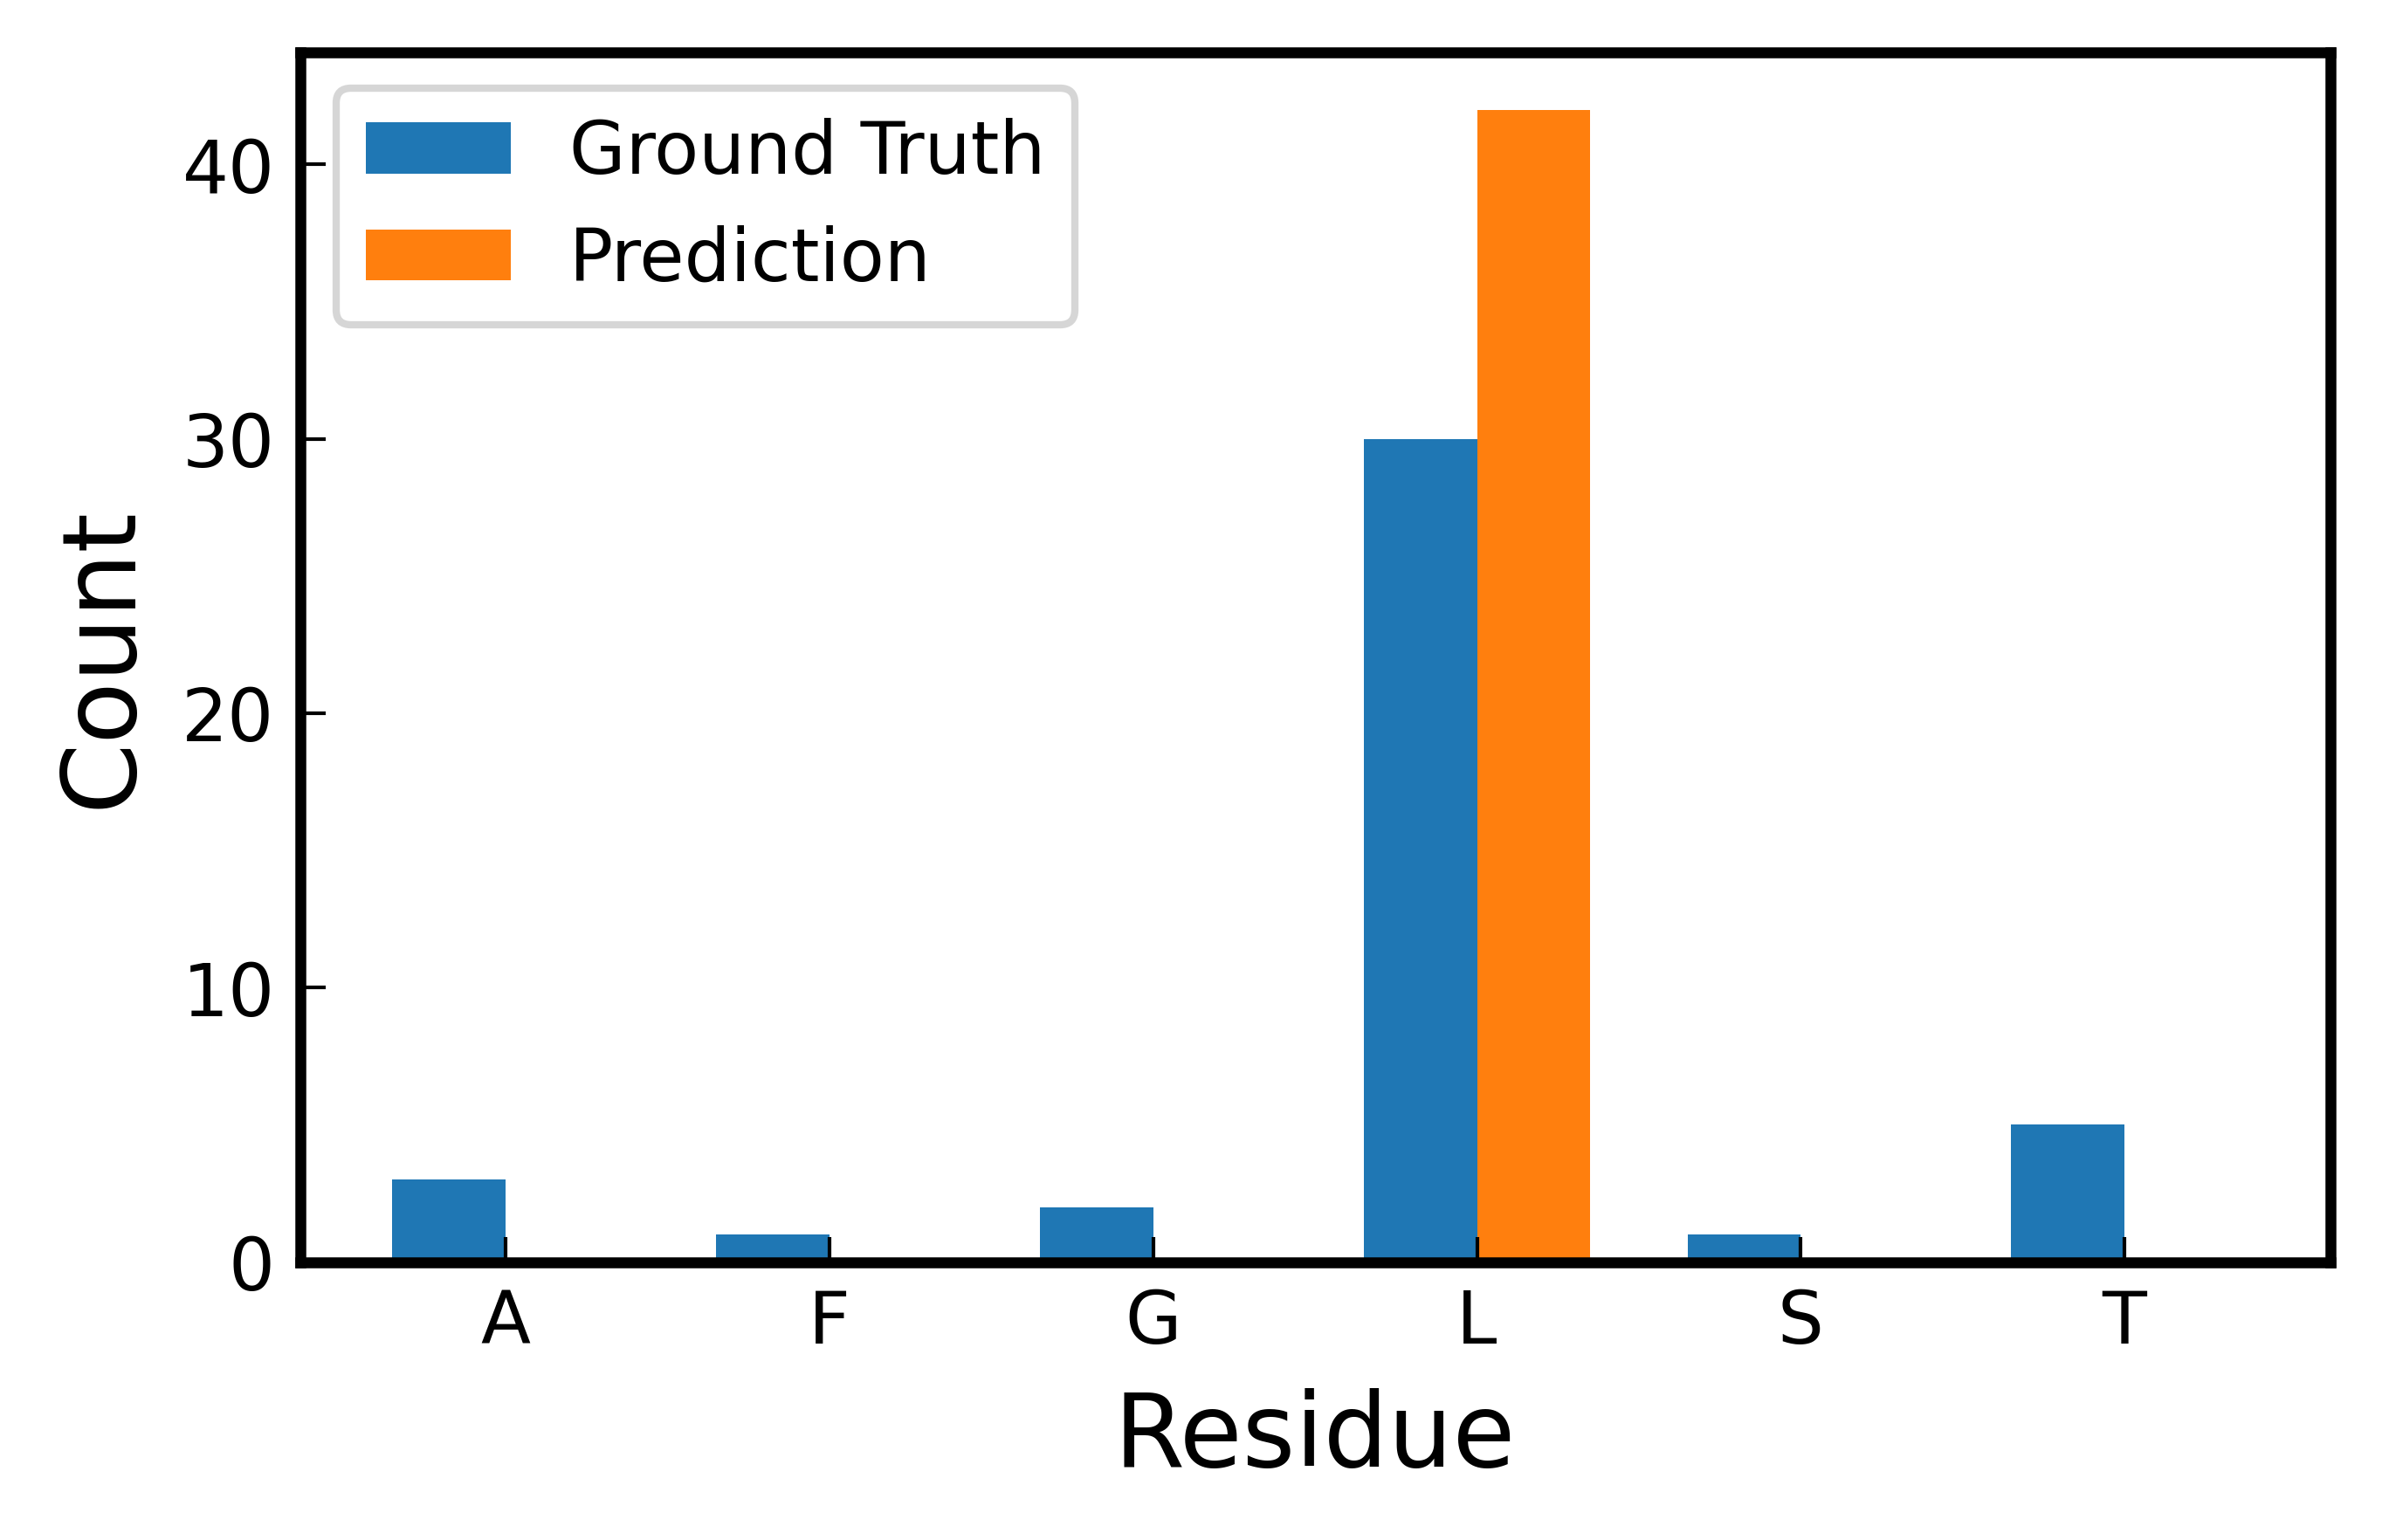

In [13]:
final_pred = pred.cpu().numpy()
final_gts = gts.cpu().numpy()

y_pred_amino = [index_to_amino_acid[i] for i in final_pred]
y_gts_amino = [index_to_amino_acid[i] for i in final_gts]

fig = bar_plot(y_gts_amino, y_pred_amino)

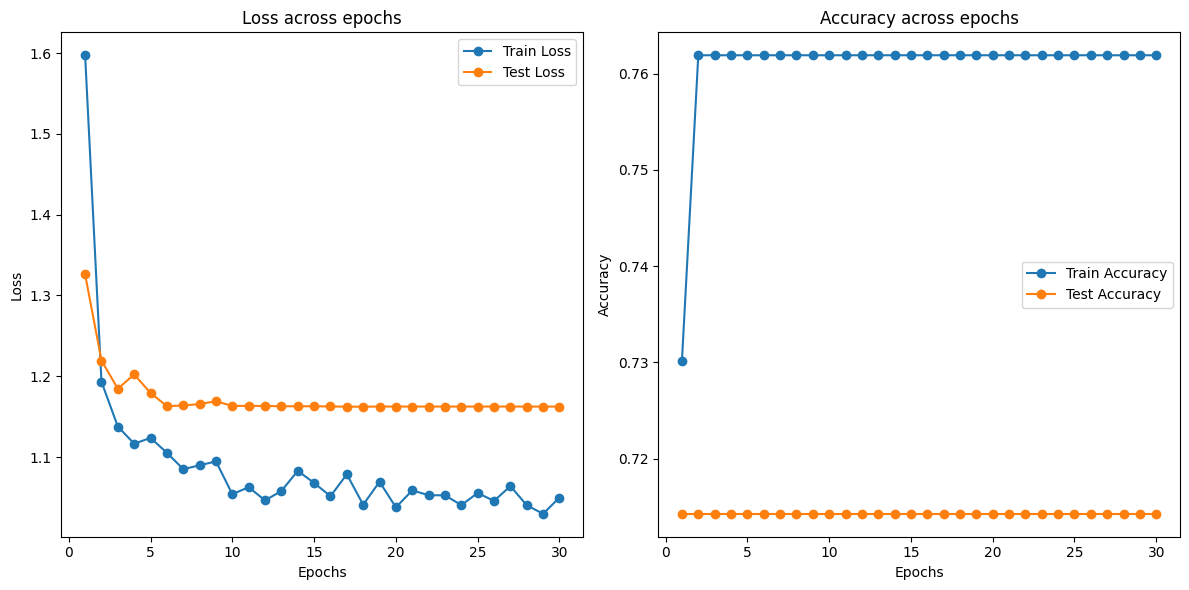

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), tr_ls, 'o-' ,label='Train Loss')
plt.plot(range(1, epochs+1), tt_ls, 'o-' , label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss across epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), tr_ac, 'o-' ,label='Train Accuracy')
plt.plot(range(1, epochs+1), tt_ac, 'o-' ,label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy across epochs')
plt.legend()

plt.tight_layout()
plt.show()